In [6]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from pypfopt import expected_returns, risk_models, EfficientFrontier
import warnings
warnings.filterwarnings('ignore')

Fetching data for TSLA...


[*********************100%***********************]  1 of 1 completed


Data for TSLA retrieved. Columns: [('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA')]
Fetching data for BND...


[*********************100%***********************]  1 of 1 completed


Data for BND retrieved. Columns: [('Close', 'BND'), ('High', 'BND'), ('Low', 'BND'), ('Open', 'BND'), ('Volume', 'BND')]
Fetching data for SPY...


[*********************100%***********************]  1 of 1 completed


Data for SPY retrieved. Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]

TSLA Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2542 entries, 2015-07-01 to 2025-08-08
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   2542 non-null   float64
 1   (High, TSLA)    2542 non-null   float64
 2   (Low, TSLA)     2542 non-null   float64
 3   (Open, TSLA)    2542 non-null   float64
 4   (Volume, TSLA)  2542 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 119.2 KB
None

BND Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2542 entries, 2015-07-01 to 2025-08-08
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, BND)   2542 non-null   float64
 1   (High, BND)    2542 non-null   float64
 2   (Low, BND)     2542 non-null   float64
 3   (

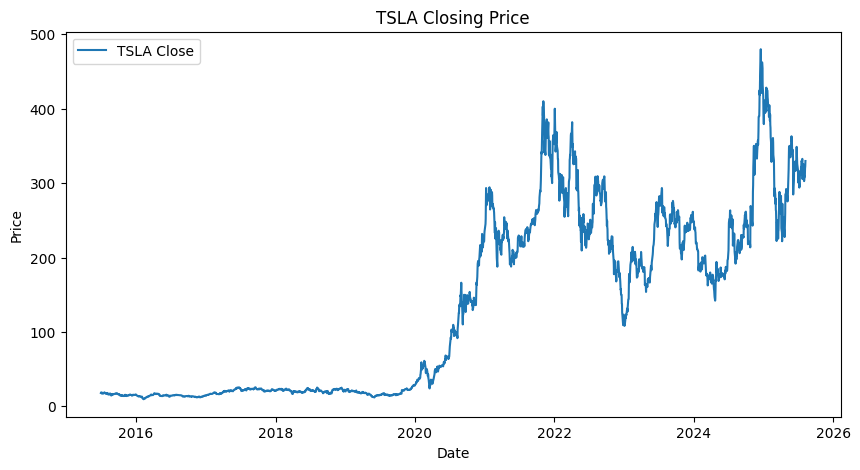

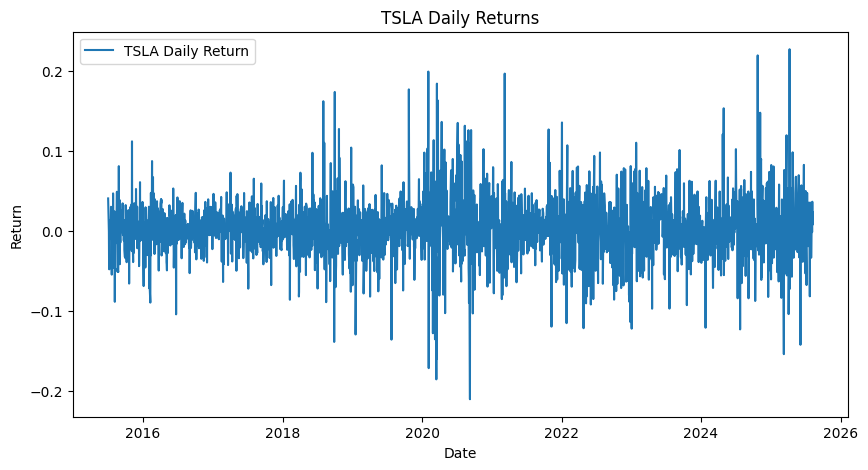

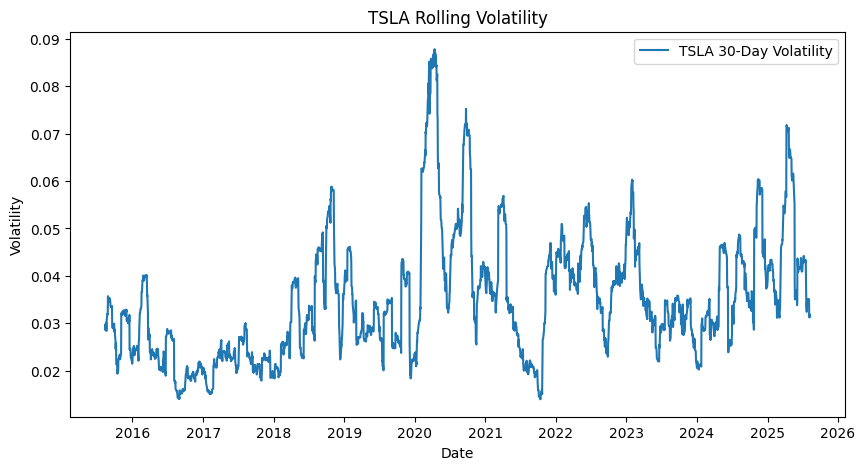

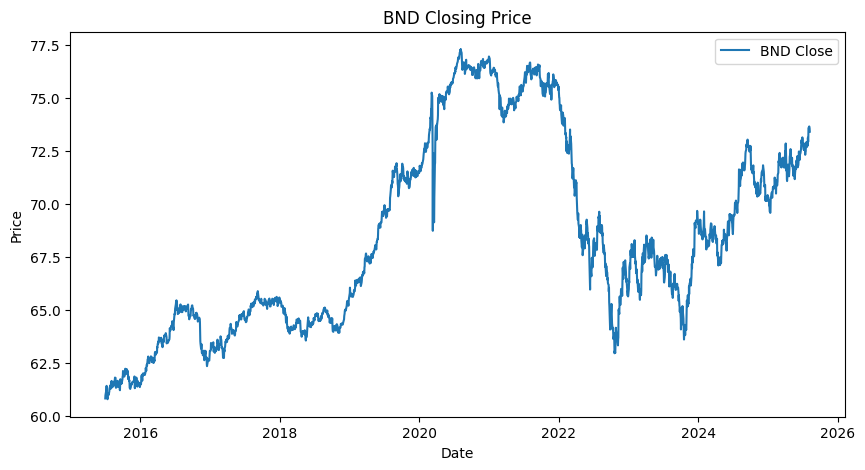

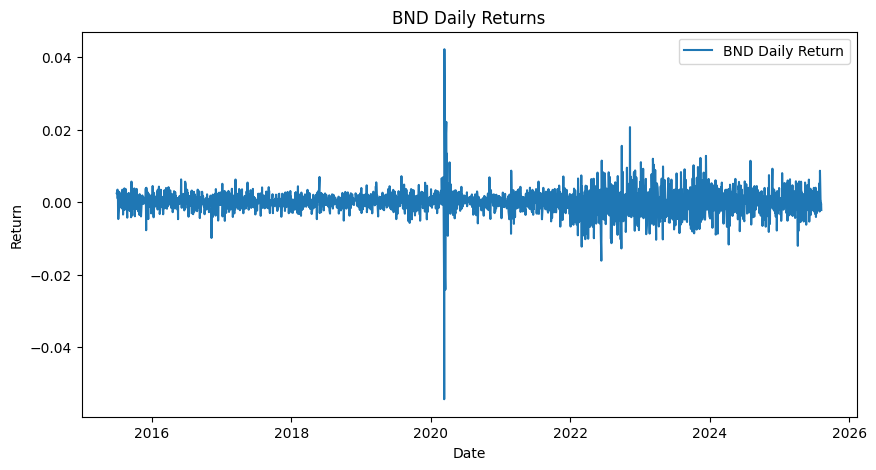

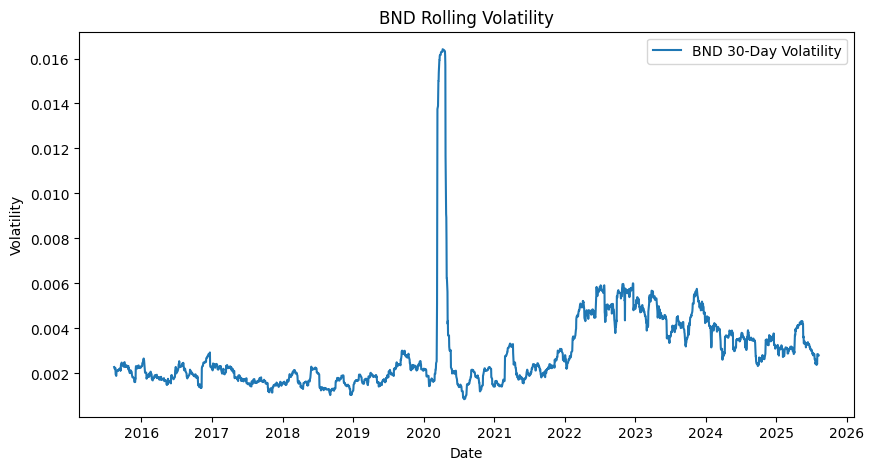

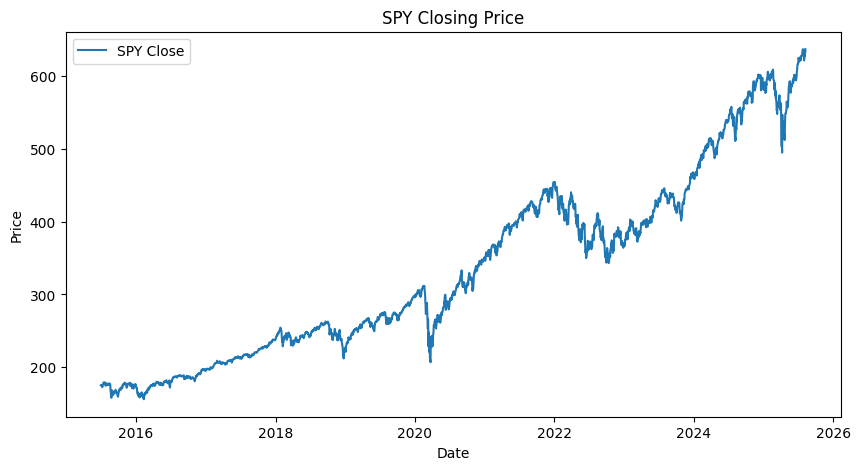

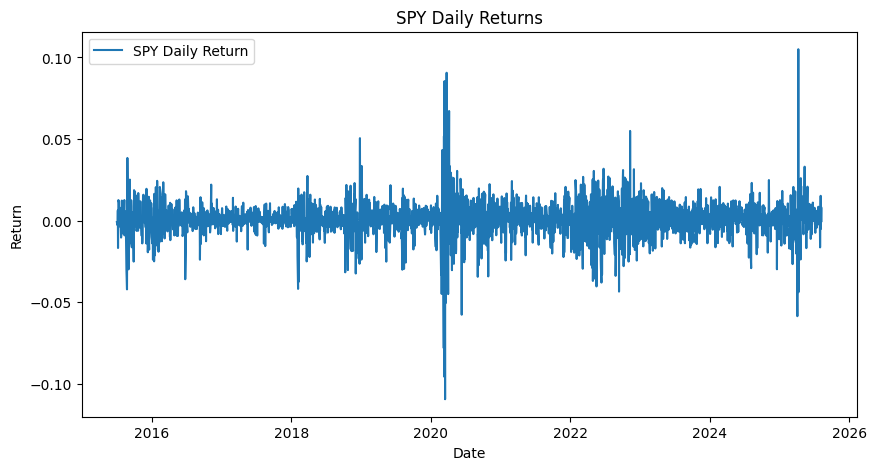

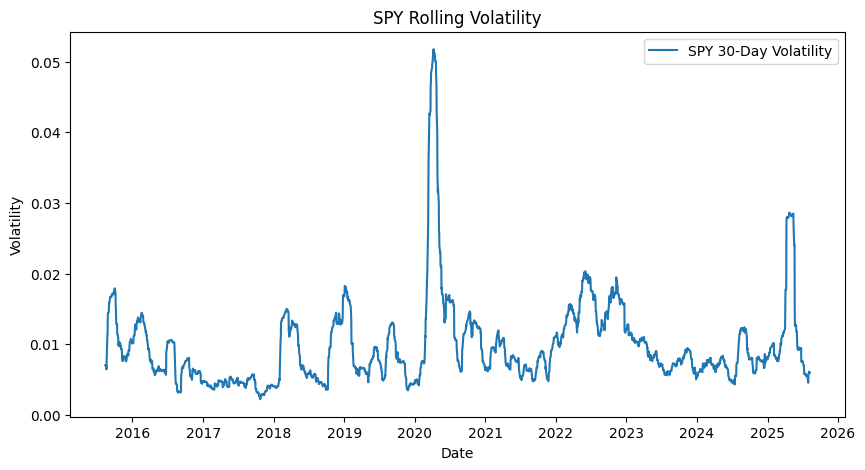


TSLA ADF Test for Close: p-value = 0.6056256969740695
TSLA ADF Test for Daily Returns: p-value = 0.0

BND ADF Test for Close: p-value = 0.5345086888247544
BND ADF Test for Daily Returns: p-value = 3.180544518349903e-17

SPY ADF Test for Close: p-value = 0.9897494147611209
SPY ADF Test for Daily Returns: p-value = 3.278519064365977e-29

TSLA 95% VaR: -0.0546, Sharpe Ratio: 0.7827

BND 95% VaR: -0.0049, Sharpe Ratio: 0.3676

SPY 95% VaR: -0.0171, Sharpe Ratio: 0.7947

Key Insights:
- TSLA: High volatility, potential upward trend.
- BND: Stable, low volatility.
- SPY: Moderate risk, tracks market.


In [10]:
# Task 1: Preprocess and Explore the Data

# Fetch data from yfinance
tickers = ['TSLA', 'BND', 'SPY']
data = {}
for ticker in tickers:
    print(f"Fetching data for {ticker}...")
    df = yf.download(ticker, start='2015-07-01', end='2025-08-11')
    if df.empty:
        print(f"Error: No data retrieved for {ticker}")
    else:
        print(f"Data for {ticker} retrieved. Columns: {df.columns.tolist()}")
        data[ticker] = df

# Check if all tickers have data
if not all(ticker in data for ticker in tickers):
    print("Error: Missing data for some tickers. Proceeding with available data.")
    available_tickers = [ticker for ticker in tickers if ticker in data]
else:
    available_tickers = tickers

# Combine closing prices (handle MultiIndex)
if isinstance(data[available_tickers[0]].columns, pd.MultiIndex):
    close_column = ('Close', available_tickers[0])  # Use 'Close' from MultiIndex
    closes = pd.DataFrame({ticker: data[ticker][('Close', ticker)] for ticker in available_tickers})
else:
    close_column = 'Close'  # Fallback if not MultiIndex
    closes = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in available_tickers})
closes.dropna(inplace=True)

# Data Cleaning
for ticker in available_tickers:
    df = data[ticker]
    print(f"\n{ticker} Data Info:")
    print(df.info())
    if isinstance(df.columns, pd.MultiIndex):
        df[('Close', ticker)].fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)
    else:
        df['Close'].fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)
    data[ticker] = df

# Basic Statistics
for ticker in available_tickers:
    print(f"\n{ticker} Basic Statistics:")
    if isinstance(df.columns, pd.MultiIndex):
        print(data[ticker][('Close', ticker)].describe())
    else:
        print(data[ticker]['Close'].describe())

# EDA: Plot closing prices, daily returns, and volatility
for ticker in available_tickers:
    df = data[ticker]
    if isinstance(df.columns, pd.MultiIndex):
        close_data = df[('Close', ticker)]
        df[('Daily Return', ticker)] = df[('Close', ticker)].pct_change()
        df[('Rolling Volatility', ticker)] = df[('Daily Return', ticker)].rolling(window=30).std()
    else:
        close_data = df['Close']
        df['Daily Return'] = df['Close'].pct_change()
        df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std()

    plt.figure(figsize=(10, 5))
    plt.plot(close_data, label=f'{ticker} Close')
    plt.title(f'{ticker} Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig(f'{ticker}_close.png')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(df[('Daily Return', ticker) if isinstance(df.columns, pd.MultiIndex) else 'Daily Return'], label=f'{ticker} Daily Return')
    plt.title(f'{ticker} Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.savefig(f'{ticker}_returns.png')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(df[('Rolling Volatility', ticker) if isinstance(df.columns, pd.MultiIndex) else 'Rolling Volatility'], label=f'{ticker} 30-Day Volatility')
    plt.title(f'{ticker} Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.savefig(f'{ticker}_volatility.png')
    plt.show()

# Stationarity Test
for ticker in available_tickers:
    df = data[ticker]
    if isinstance(df.columns, pd.MultiIndex):
        adf_close = adfuller(df[('Close', ticker)])
        adf_return = adfuller(df[('Daily Return', ticker)].dropna())
    else:
        adf_close = adfuller(df['Close'])
        adf_return = adfuller(df['Daily Return'].dropna())
    print(f"\n{ticker} ADF Test for Close: p-value = {adf_close[1]}")
    print(f"{ticker} ADF Test for Daily Returns: p-value = {adf_return[1]}")

# Volatility Analysis
for ticker in available_tickers:
    df = data[ticker]
    daily_return = df[('Daily Return', ticker) if isinstance(df.columns, pd.MultiIndex) else 'Daily Return']
    var_95 = np.percentile(daily_return.dropna(), 5)
    sharpe = (daily_return.mean() * 252) / (daily_return.std() * np.sqrt(252))
    print(f"\n{ticker} 95% VaR: {var_95:.4f}, Sharpe Ratio: {sharpe:.4f}")

print("\nKey Insights:")
print("- TSLA: High volatility, potential upward trend.")
print("- BND: Stable, low volatility.")
print("- SPY: Moderate risk, tracks market.")